In [2]:
%matplotlib widget
import numpy as np
import scipy
import obspy
from obspy.signal.cross_correlation import correlate, xcorr_max
from obspy.clients.fdsn.mass_downloader import RectangularDomain, Restrictions, MassDownloader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
from scipy.signal import spectrogram
import datetime
from geopy.distance import distance
import glob
import time
import os

In [ ]:
'''

Download data

'''

domain = RectangularDomain(minlatitude=-90, maxlatitude=90, minlongitude=-180, maxlongitude=180.0)

restrictions = Restrictions(
    starttime=obspy.UTCDateTime(2010, 1, 1),
    endtime=obspy.UTCDateTime(2022, 1, 1),
    chunklength_in_sec=86400,
    network="YT", station="MA01,MA02,MA08,MCRG", location="", channel="HH*",
    location_priorities = ["01",],
    channel_priorities = ["HHZ","HHN","HHE"],
    reject_channels_with_gaps=False,
    minimum_length=0.0)

mseed_storage=("/media/Data/Data/YT/MSEED/raw/")

mdl = MassDownloader(providers=["IRIS"])

mdl.download(
    domain=domain,
    restrictions=restrictions, 
    mseed_storage=mseed_storage, 
    stationxml_storage=("/media/Data/Data/YT/XML/"))


In [ ]:
'''

Set station and channel info

'''

path = "/media/Data/Data/"
networks = ["YT"]
stats = [["MCRG","MA01","MA02","MA08"]]
chans = ["HH*"]

In [ ]:
'''

Remove instrumental response

'''

# set times of interest
time_win_dict = {}
time_win_dict[0] = {'start':datetime.datetime(2011,10,2),'end':datetime.datetime(2011,10,10)}
time_win_dict[1] = {'start':datetime.datetime(2012,5,8),'end':datetime.datetime(2012,5,10)}
time_win_dict[2] = {'start':datetime.datetime(2015,7,8),'end':datetime.datetime(2015,7,20)}
time_win_dict[3] = {'start':datetime.datetime(2017,9,13),'end':datetime.datetime(2017,9,25)}
time_win_dict[4] = {'start':datetime.datetime(2018,9,21),'end':datetime.datetime(2018,10,25)}

#set frequency band for response removal
prefilt = [[0.0005,0.001,45,50]]

for i in range(len(time_win_dict)):
    for n in range(len(networks)):
        duration = time_win_dict[i]['end']-time_win_dict[i]['start']
        files = []
        for day in range(0,duration.days):
            date = time_win_dict[i]['start']+datetime.timedelta(days=day)
            files.extend([path + networks[n] + "/MSEED/raw/" + stat + "/*" + chans[n] + "__" + str(date.year) + date.strftime('%m') + date.strftime('%d') + "T000000Z__" + "*" for stat in stats[n]])

        #loop through all raw files
        for f in files:

            #start timer
            t = time.time()

            #read in one data file
            try:
                st = obspy.read(f)
            except:
                print("No data for " + str(f))
                continue
                
            #grab a couple useful variables from file metadata
            station = st[0].stats.station
            channel = st[0].stats.channel
            start_date = str(st[0].stats.starttime).split("T")[0]

            #specify output filename format
            out_path = "data/MSEED/"+networks[n]+"/"
            out_file = out_path + st[0].stats.station + "_" + start_date + "_" + str(prefilt[n][1]) + "-" + str(prefilt[n][2]) + "Hz.MSEED"
            if not os.path.exists(out_path):
                os.makedirs(out_path)

            #preprocess file
            st.detrend("demean")
            st.detrend("linear")
            st.taper(max_percentage=0.00025, max_length=20.)

            #read correct stationXML file
            XML_path = glob.glob(path + networks[n] + "/XML/*" + station + "*.xml")[0]
            inv = obspy.read_inventory(XML_path)

            #remove instrument response
            st.remove_response(inventory=inv,pre_filt=prefilt[n],output="VEL")

            #write new file
            st.write(out_file,format='MSEED')

            #end timer
            run_time = time.time() - t

            #give some output to check progress
            print("Response removed from " + f + " in " + str(run_time) + " seconds.")

In [ ]:
'''

Check which stations are available for times where imagery suggests rift activity

'''

# set times of interest
time_win_dict = {}
time_win_dict[0] = {'start':datetime.datetime(2011,10,2),'end':datetime.datetime(2011,10,10)}
time_win_dict[1] = {'start':datetime.datetime(2015,7,8),'end':datetime.datetime(2015,7,20)}
time_win_dict[2] = {'start':datetime.datetime(2017,9,13),'end':datetime.datetime(2017,9,25)}
time_win_dict[3] = {'start':datetime.datetime(2018,9,21),'end':datetime.datetime(2018,10,25)}

# plot station availability during times of interest
fig = plt.figure(figsize=(15,5))
position = 0
for n in range(len(networks)):
    for s in range(len(stats[n])):
        files = glob.glob(path + networks[n] + "/MSEED/raw/" + stats[n][s] + "/*" + chans[n] + "*")
        dates = [datetime.datetime.strptime(f.split("__")[1],"%Y%m%dT000000Z") for f in files]
        plt.plot(dates,np.ones(len(dates))+position,label=stats[n][s])
        position += 1
plt.legend()
plt.title("Station availability")
plt.show()

rifts = ["2011 rift","2015 rift","2017 rift", "2018 rift"]
fig,ax = plt.subplots(len(time_win_dict),figsize=(10,12))
position = 0
for i in range(len(time_win_dict)):
    for n in range(len(networks[n])):
        for s in range(len(stats[n])):
            files = glob.glob(path + networks[n] + "/MSEED/raw/" + stats[n][s] + "/*" + chans[n] + "*")
            dates = np.array([datetime.datetime.strptime(f.split("__")[1],"%Y%m%dT000000Z") for f in files])
            time_ind = np.logical_and([dates>time_win_dict[i]['start']],[dates<time_win_dict[i]['end']])[0]
            ax[i].plot(dates[time_ind],np.ones(len(dates[time_ind]))+position,label=stats[n][s])
            position+=1
    ax[i].set_title(rifts[i])
    ax[i].legend()
plt.tight_layout()

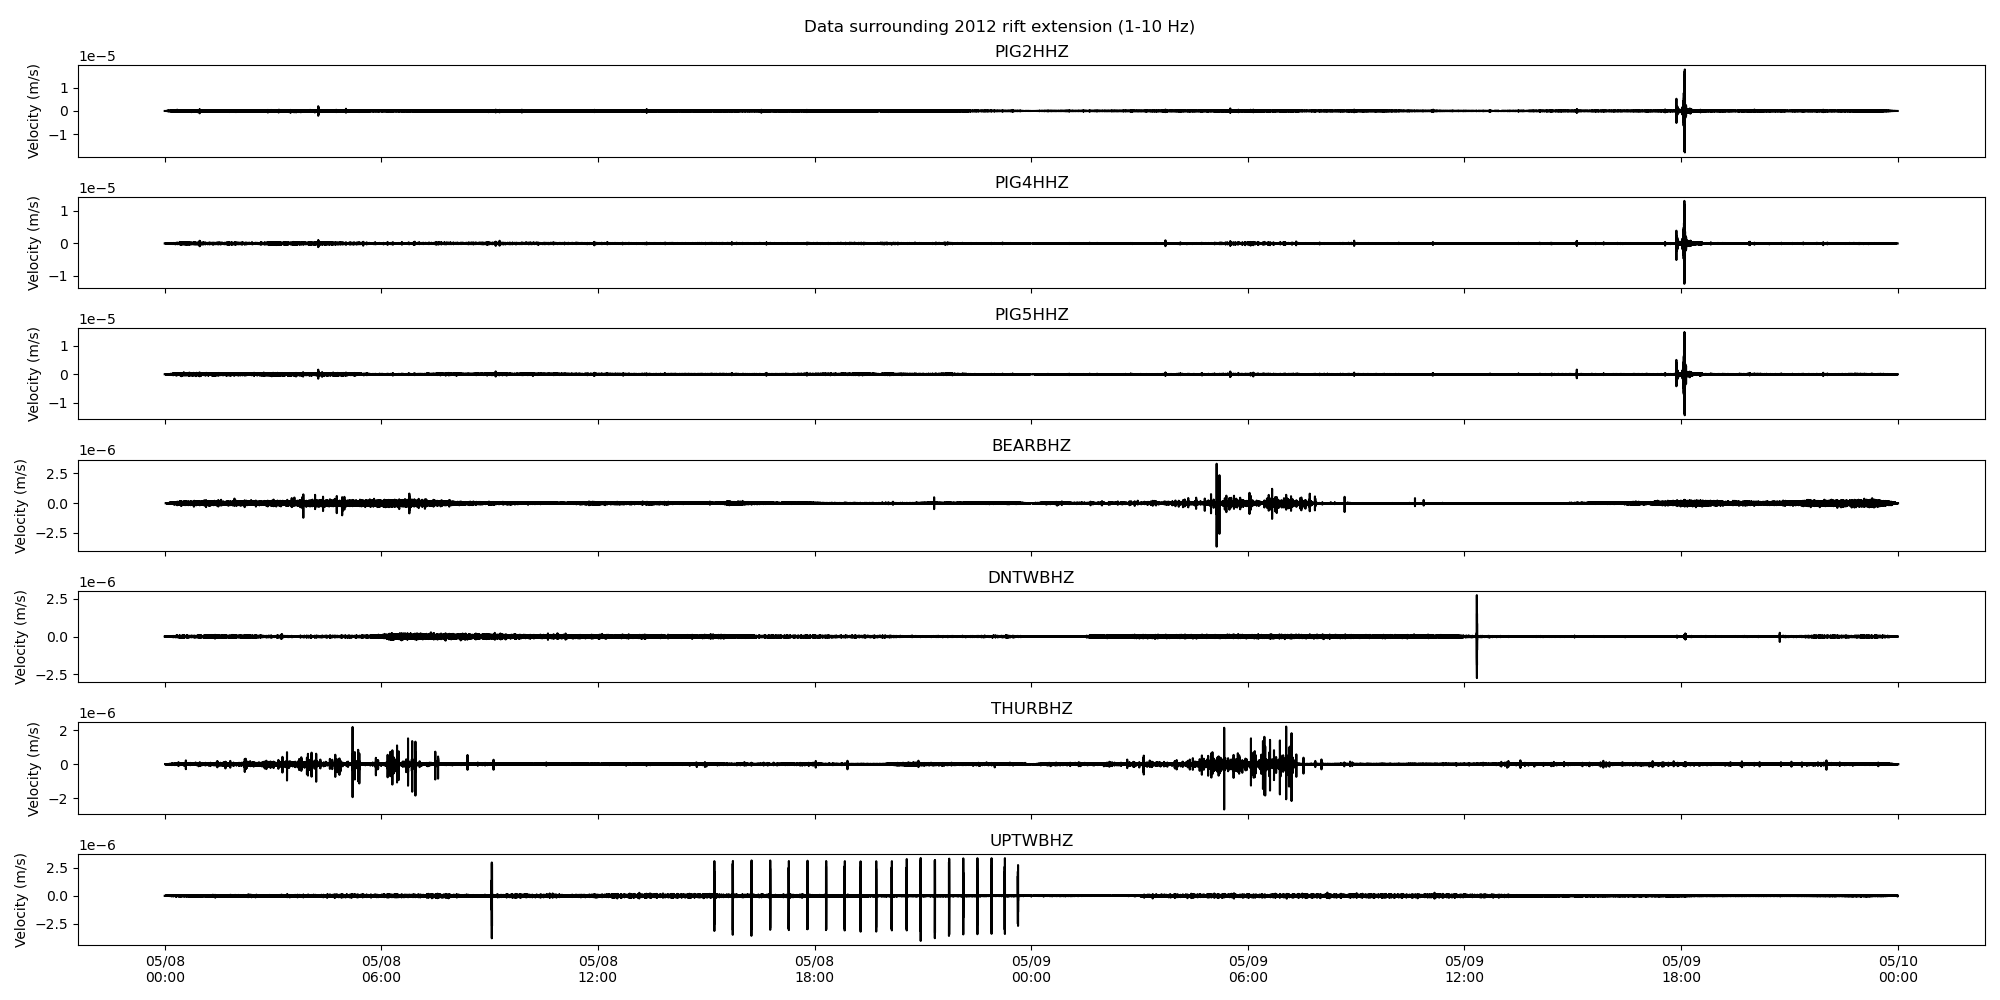

In [4]:
'''

Plot all available data for each time period of interest

'''

# set times of interest
time_win_dict = {}
#time_win_dict[0] = {'start':datetime.datetime(2011,10,2),'end':datetime.datetime(2011,10,10)}
time_win_dict[0] = {'start':datetime.datetime(2012,5,8),'end':datetime.datetime(2012,5,10)}
#time_win_dict[1] = {'start':datetime.datetime(2015,7,8),'end':datetime.datetime(2015,7,20)}
#time_win_dict[2] = {'start':datetime.datetime(2017,9,13),'end':datetime.datetime(2017,9,25)}
#time_win_dict[3] = {'start':datetime.datetime(2018,9,21),'end':datetime.datetime(2018,10,25)}

# choose channel and frequency band
chan = "*Z"
low_cut = 1
high_cut = 10

# make labels for plots
#rifts = ["2011 rift","2015 rift","2017 rift", "2018 rift"]
rifts = ["2012 rift"]

for i in range(len(time_win_dict)):
    data_dict = {}
    # read all data available on the current day
    duration = time_win_dict[i]['end']-time_win_dict[i]['start']
    for day in range(0,duration.days):

        # get date from time window dictionary
        date = time_win_dict[i]['start']+datetime.timedelta(days=day)

        # read and preprocess data
        st = obspy.read("data/MSEED/*/*" + str(date.year) + "-" + date.strftime('%m') + "-" + date.strftime('%d') + "*")
        st.detrend("demean")
        st.detrend("linear")
        st.taper(max_percentage=0.00025, max_length=20.)
        st.filter("bandpass",freqmin=low_cut,freqmax=high_cut)
        st.resample(high_cut*2)
        
        for tr in st.select(channel=chan):
            data_key = tr.stats.station+tr.stats.channel+"_data"
            time_key = tr.stats.station+tr.stats.channel+"_time"
            if data_key in data_dict.keys():
                data_dict[data_key] = np.append(data_dict[data_key],tr.data)
                data_dict[time_key] = np.append(data_dict[time_key],tr.times(type="matplotlib"))
            else:
                data_dict[data_key] = tr.data
                data_dict[time_key] = tr.times(type="matplotlib")

    fig,ax = plt.subplots(len(data_dict)//2,1,figsize=(20,10))
    data_keys = [k for k in data_dict.keys() if "data" in k]
    time_keys = [k for k in data_dict.keys() if "time" in k]
    nrows = len(data_keys)-1
    for k in range(len(data_keys)):
        ax[k].plot(data_dict[time_keys[k]],data_dict[data_keys[k]],color='k')
        ax[k].get_xaxis().set_ticklabels([])
        ax[nrows].get_shared_x_axes().join(ax[nrows],ax[k])
        ax[k].set_ylabel("Velocity (m/s)")
        ax[k].set_title(data_keys[k].split("_")[0])
        if k == nrows:
            ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
    plt.suptitle("Data surrounding " + rifts[i] + " extension (" + str(low_cut)+"-" + str(high_cut)+" Hz)")
    plt.tight_layout()
    plt.savefig("outputs/timeseries/" + time_win_dict[i]['start'].strftime("%Y-%m-%d") + "_" + time_win_dict[i]['end'].strftime("%Y-%m-%d") + "_" + chan.split("*")[1] + "_" + str(low_cut)+ "-" + str(high_cut)+ "Hz" + ".png")